The Setup
You have a coin, but you don't know if it's fair. You flip it 10 times and get 7 heads. What's the probability distribution for the coin's true bias (θ)?
Why you need MC
The prior is Beta(1,1) (uniform), likelihood is binomial. Now here's the twist: suppose your measurement isn't perfect — each flip has a 10% chance of being recorded wrong (heads recorded as tails or vice versa).
This "noisy observation" makes the posterior analytically messy, so you'll need to sample it.
Your task

Write down the likelihood P(data | θ) accounting for the noise
Use Metropolis-Hastings to sample from the posterior
Plot the posterior distribution of θ

For each flip, think about the probability of observing heads given the true bias θ and the noise:
P(observe H | θ) = P(actually H) × P(recorded correctly) + P(actually T) × P(recorded wrong)
So that's:
P(observe H | θ) = θ × 0.9 + (1-θ) × 0.1
Now you have an effective probability of observing heads, call it θ_eff. Your likelihood for 7 heads out of 10 is just binomial with this θ_eff.

You only ever compute the ratio of posteriors:
α = P(θ_new | data) / P(θ_old | data)
The P(data) in the denominator is the same for both, so it cancels out. You never need to compute it.
That's exactly why MC methods are so powerful for Bayesian inference — you can sample from the posterior without knowing the normalization constant.

Metropolis-Hastings loop:
1. Initialize
Pick a starting value θ_current (say 0.5)
2. Propose
Generate θ_new by adding small random noise to θ_current, like:
θ_new = θ_current + Normal(0, σ)
(σ is your step size, maybe 0.1 to start)
3. Compute acceptance ratio
α = [L(θ_new) × Prior(θ_new)] / [L(θ_current) × Prior(θ_current)]
Since prior is uniform, it cancels — just the likelihood ratio.
4. Accept or reject

Draw u ~ Uniform(0,1)
If u < α: accept, set θ_current = θ_new
Else: stay at θ_current

5. Store and repeat
Save θ_current to your chain, go back to step 2. Do this ~10,000 times.
6. Burn-in
Throw away first ~1000 samples (the chain needs time to "forget" the starting point)
One gotcha: if θ_new falls outside [0,1], just reject it automatically.

Few things you could try next if you want to explore more:

Compare with no-noise case — plot both posteriors on same axes, you'll see the noisy one is wider (more uncertain)
Play with the noise level — what happens if misrecording rate is 20%? 30%? The posterior should get wider and shift toward 0.5
Check convergence — plot θ vs iteration number (trace plot) to make sure the chain is mixing well

In [1]:
import math
import numpy as np


# Calculate C(10, 7)
result = math.comb(10, 7)
print(f"C(10, 7) = {result}")

C(10, 7) = 120


In [2]:
import math
import numpy as np


# Calculate C(10, 7)
result = math.comb(10, 7)

data={'H','H','H','H','H','H','H','T','T','T'}

# likelihood function
def likelihood(theta, misrecording_rate):
  theta_eff  = theta * (1 - misrecording_rate) + (1 - theta) * misrecording_rate # noisy or no-noise
  likelihood = math.comb(10, 7) * (theta_eff**7) * ((1-theta_eff)**3)
  return likelihood

def run_mcmc_simulation(misrecording_rate, number_of_samples, theta_old=0.5, d_theta=0.05):
    MCMC_samples_list = []
    current_theta = theta_old

    while len(MCMC_samples_list) < number_of_samples:
        proposed_theta = np.random.normal(current_theta, d_theta, 1)[0]

        # Handle boundary conditions for theta [0, 1]
        if proposed_theta < 0 or proposed_theta > 1:
            MCMC_samples_list.append(float(current_theta))
            continue

        # Calculate acceptance ratio
        alpha = likelihood(proposed_theta, misrecording_rate) / likelihood(current_theta, misrecording_rate)

        if alpha >= 1:
            MCMC_samples_list.append(float(proposed_theta))
            current_theta = proposed_theta
        elif np.random.uniform(0, 1, 1)[0] < alpha:
            MCMC_samples_list.append(float(proposed_theta))
            current_theta = proposed_theta
        else:
            MCMC_samples_list.append(float(current_theta))
    return MCMC_samples_list


# Generate MCMC samples for original 10% noise case
misrecording_rate_original = 0.1 # This is the original 10% noise case
number_of_samples = 1_000_000

MCMC_samples = run_mcmc_simulation(misrecording_rate_original, number_of_samples)

In [3]:
burn_in = 1_000
MCMC_samples_burn_in = MCMC_samples[burn_in:]

## Calculate Mean and Standard Deviation

In [4]:
mean_MCMC_samples = np.mean(MCMC_samples_burn_in)
std_MCMC_samples = np.std(MCMC_samples_burn_in)

print(f"Mean of MCMC_samples_burn_in: {mean_MCMC_samples:.3f}")
print(f"Standard deviation of MCMC_samples_burn_in: {std_MCMC_samples:.3f}")

Mean of MCMC_samples_burn_in: 0.704
Standard deviation of MCMC_samples_burn_in: 0.158


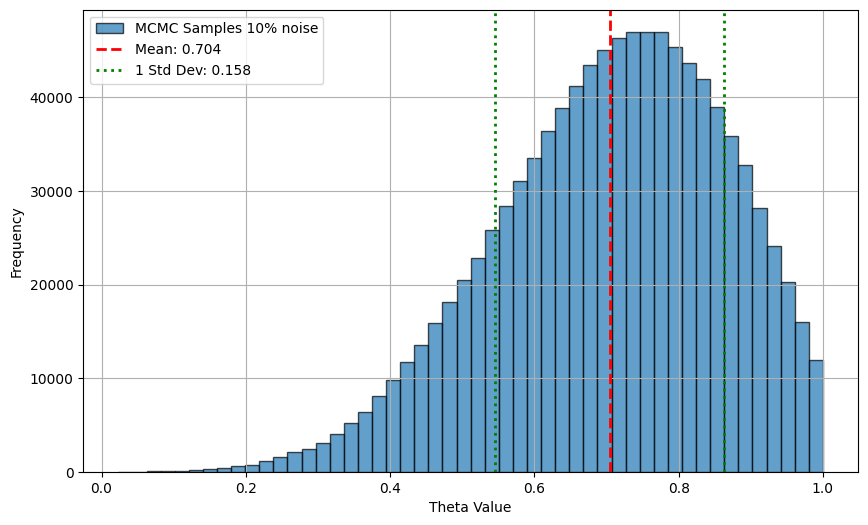

In [5]:
import matplotlib.pyplot as plt

# create the histogram
plt.figure(figsize=(10, 6))
plt.hist(MCMC_samples_burn_in, bins=50, edgecolor='black', alpha=0.7, label='MCMC Samples 10% noise')

# Add vertical line for the mean
plt.axvline(mean_MCMC_samples, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_MCMC_samples:.3f}')

# Add vertical lines for one standard deviation
plt.axvline(mean_MCMC_samples - std_MCMC_samples, color='green', linestyle=':', linewidth=2, label=f'1 Std Dev: {std_MCMC_samples:.3f}')
plt.axvline(mean_MCMC_samples + std_MCMC_samples, color='green', linestyle=':', linewidth=2)

# plt.title('Annotated Histogram of MCMC Samples After Burn-in')
plt.xlabel('Theta Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
# Generate MCMC samples for no noise case
misrecording_rate = 0.0
number_of_samples = 1_000_000
MCMC_samples_no_noise = run_mcmc_simulation(misrecording_rate, number_of_samples)

# Generate MCMC samples for 20% noise case
misrecording_rate = 0.2
number_of_samples = 1_000_000
MCMC_samples_20_noise = run_mcmc_simulation(misrecording_rate, number_of_samples)

# Generate MCMC samples for 30% noise case
misrecording_rate = 0.3
number_of_samples = 1_000_000
MCMC_samples_30_noise = run_mcmc_simulation(misrecording_rate, number_of_samples)

# Generate MCMC samples for 50% noise case
misrecording_rate = 0.5
number_of_samples = 1_000_000
MCMC_samples_50_noise = run_mcmc_simulation(misrecording_rate, number_of_samples)
#####################################################################################
burn_in = 1_000
MCMC_samples_no_noise_burn_in = MCMC_samples_no_noise[burn_in:]
MCMC_samples_20_noise_burn_in = MCMC_samples_20_noise[burn_in:]
MCMC_samples_30_noise_burn_in = MCMC_samples_30_noise[burn_in:]
MCMC_samples_50_noise_burn_in = MCMC_samples_50_noise[burn_in:]

print(f"Burn-in applied to MCMC_samples_no_noise. Length before: {len(MCMC_samples_no_noise)}, Length after: {len(MCMC_samples_no_noise_burn_in)}")
print(f"Burn-in applied to MCMC_samples_20_noise. Length before: {len(MCMC_samples_20_noise)}, Length after: {len(MCMC_samples_20_noise_burn_in)}")
print(f"Burn-in applied to MCMC_samples_30_noise. Length before: {len(MCMC_samples_30_noise)}, Length after: {len(MCMC_samples_30_noise_burn_in)}")
print(f"Burn-in applied to MCMC_samples_50_noise. Length before: {len(MCMC_samples_50_noise)}, Length after: {len(MCMC_samples_50_noise_burn_in)}")

Burn-in applied to MCMC_samples_no_noise. Length before: 1000000, Length after: 999000
Burn-in applied to MCMC_samples_20_noise. Length before: 1000000, Length after: 999000
Burn-in applied to MCMC_samples_30_noise. Length before: 1000000, Length after: 999000
Burn-in applied to MCMC_samples_50_noise. Length before: 1000000, Length after: 999000


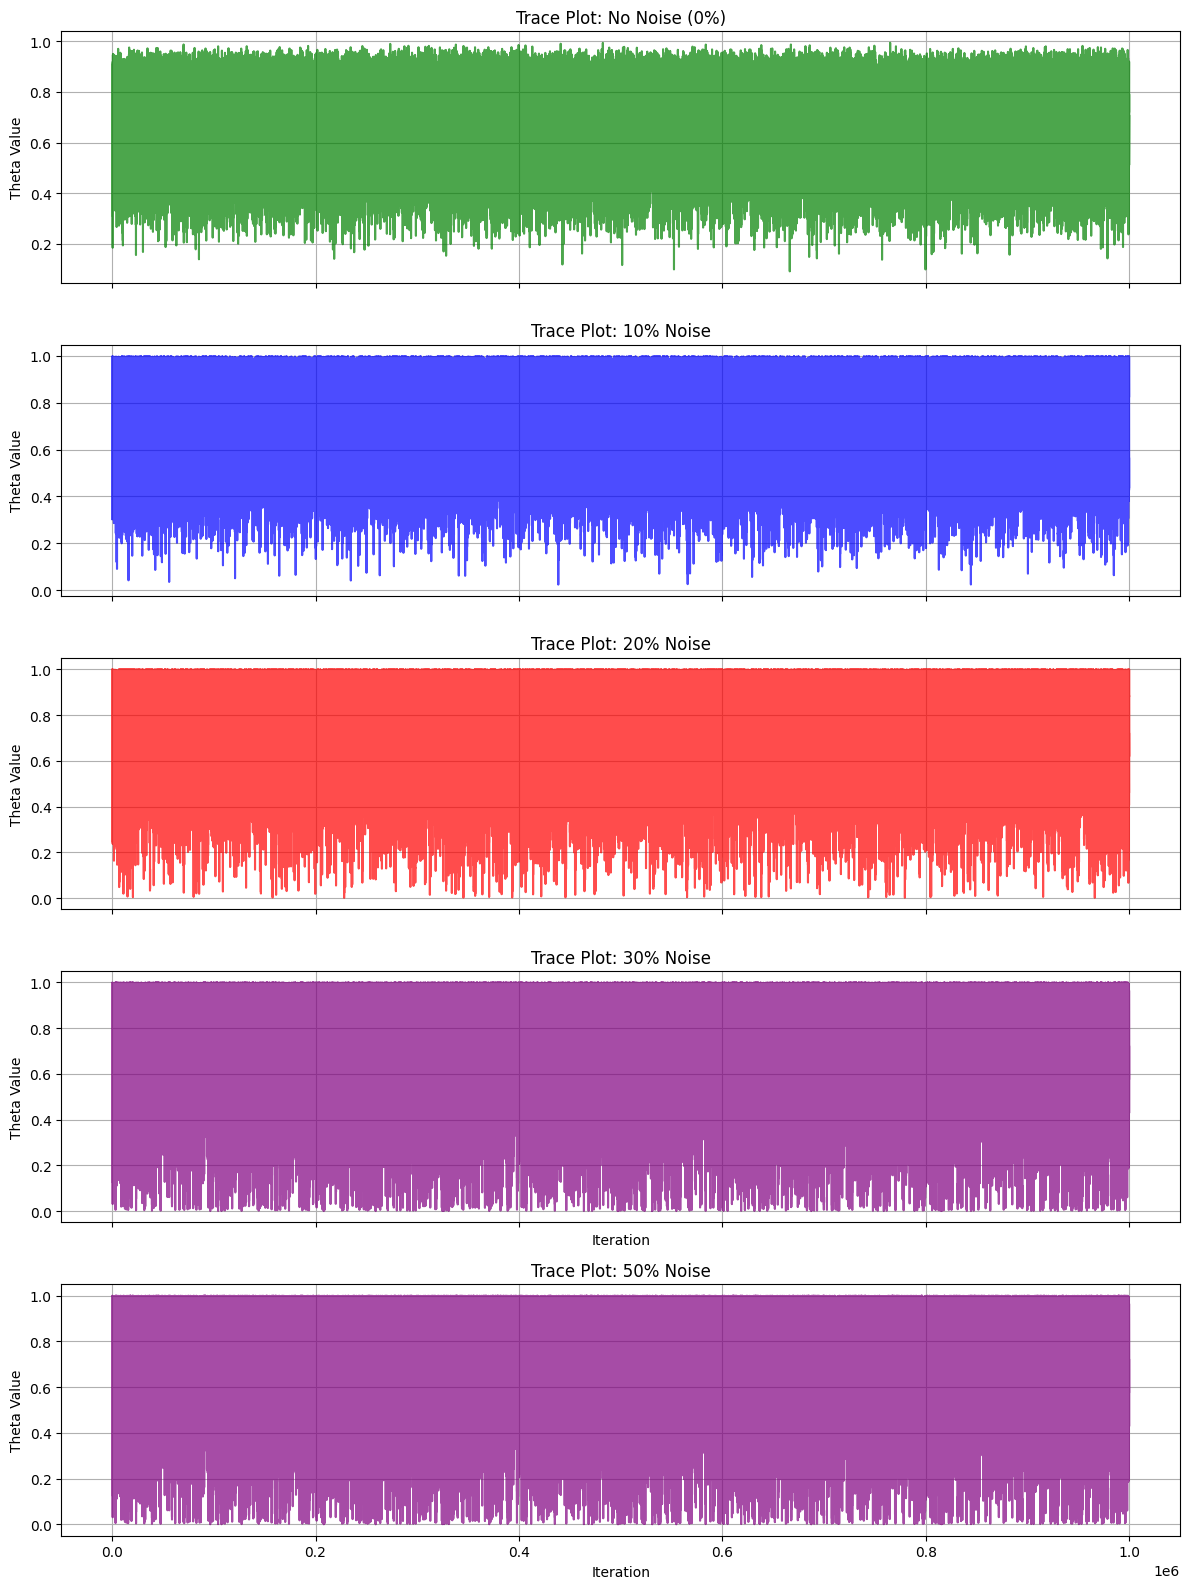

In [7]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 16), sharex=True)


# Plot for No Noise (0%)
axes[0].plot(MCMC_samples_no_noise, color='green', alpha=0.7)
axes[0].set_title('Trace Plot: No Noise (0%)')
axes[0].set_ylabel('Theta Value')
axes[0].grid(True)

# Plot for Original 10% Noise
axes[1].plot(MCMC_samples, color='blue', alpha=0.7)
axes[1].set_title('Trace Plot: 10% Noise')
axes[1].set_ylabel('Theta Value')
axes[1].grid(True)

# Plot for 20% Noise
axes[2].plot(MCMC_samples_20_noise, color='red', alpha=0.7)
axes[2].set_title('Trace Plot: 20% Noise')
axes[2].set_ylabel('Theta Value')
axes[2].grid(True)

# Plot for 30% Noise
axes[3].plot(MCMC_samples_30_noise, color='purple', alpha=0.7)
axes[3].set_title('Trace Plot: 30% Noise')
axes[3].set_ylabel('Theta Value')
axes[3].set_xlabel('Iteration')
axes[3].grid(True)

# Plot for 30% Noise
axes[4].plot(MCMC_samples_30_noise, color='purple', alpha=0.7)
axes[4].set_title('Trace Plot: 50% Noise')
axes[4].set_ylabel('Theta Value')
axes[4].set_xlabel('Iteration')
axes[4].grid(True)

plt.tight_layout()
plt.show()

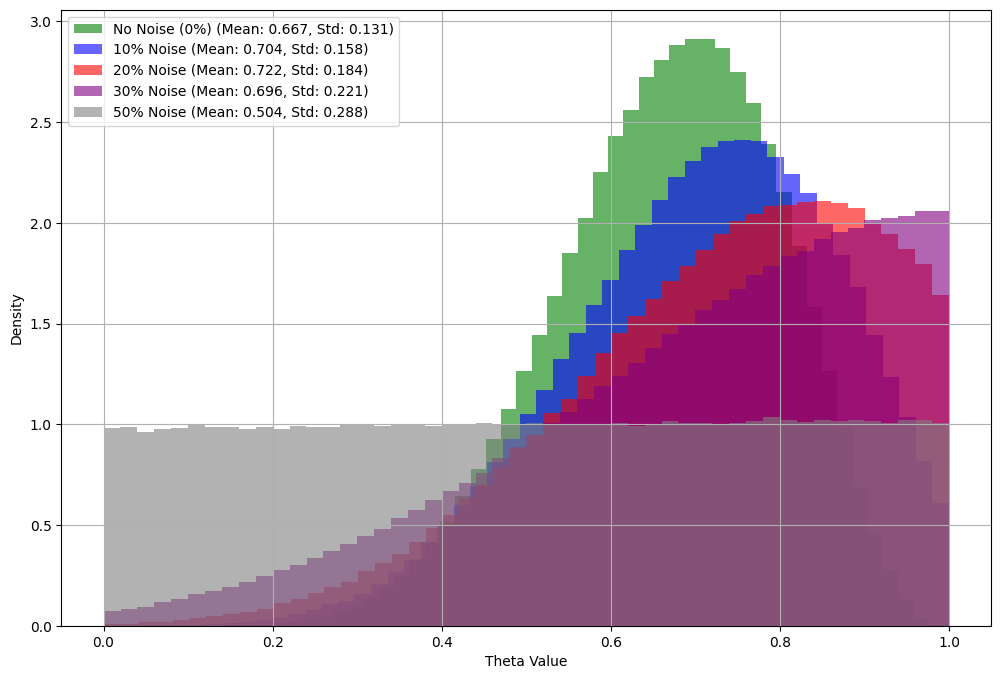

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# No Noise (0%)
plt.hist(MCMC_samples_no_noise_burn_in, bins=50, density=True, alpha=0.6, label=f'No Noise (0%) (Mean: {np.mean(MCMC_samples_no_noise_burn_in):.3f}, Std: {np.std(MCMC_samples_no_noise_burn_in):.3f})', color='green')

# Original 10% Noise
plt.hist(MCMC_samples_burn_in, bins=50, density=True, alpha=0.6, label=f'10% Noise (Mean: {np.mean(MCMC_samples_burn_in):.3f}, Std: {np.std(MCMC_samples_burn_in):.3f})', color='blue')

# 20% Noise
plt.hist(MCMC_samples_20_noise_burn_in, bins=50, density=True, alpha=0.6, label=f'20% Noise (Mean: {np.mean(MCMC_samples_20_noise_burn_in):.3f}, Std: {np.std(MCMC_samples_20_noise_burn_in):.3f})', color='red')

# 30% Noise
plt.hist(MCMC_samples_30_noise_burn_in, bins=50, density=True, alpha=0.6, label=f'30% Noise (Mean: {np.mean(MCMC_samples_30_noise_burn_in):.3f}, Std: {np.std(MCMC_samples_30_noise_burn_in):.3f})', color='purple')

# 50% Noise
plt.hist(MCMC_samples_50_noise_burn_in, bins=50, density=True, alpha=0.6, label=f'50% Noise (Mean: {np.mean(MCMC_samples_50_noise_burn_in):.3f}, Std: {np.std(MCMC_samples_50_noise_burn_in):.3f})', color='grey')

# plt.title('Histograms of MCMC Samples After Burn-in for Different Noise Levels')
plt.xlabel('Theta Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()